# DALL-E in Pytorch

Implementation / replication of DALL-E (paper), OpenAI's Text to Image Transformer, in Pytorch. It will also contain CLIP for ranking the generations.

API : https://ainize.ai/scy6500/DALLE-server

## Installation

In [1]:
!pip install einops==0.3.2

In [2]:
!pip install dalle-pytorch==0.14.3

In [3]:
!pip install deepspeed==0.4.2

In [4]:
!pip install triton==0.4.2

In [5]:
!pip install Pillow==8.2.0

## Import packages

In [6]:
%matplotlib inline
import base64
from io import BytesIO

import torch
import numpy as np
import matplotlib.pyplot as plt

# vision imports
from PIL import Image
# dalle related classes and utils
from dalle_pytorch import VQGanVAE, DALLE
from dalle_pytorch.tokenizer import tokenizer
from einops import repeat

## Download DALL-E model

Click [here](https://github.com/robvanvolt/DALLE-models) to see more models.

In [7]:
!wget https://www.dropbox.com/s/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt

--2021-11-17 07:45:16--  https://www.dropbox.com/s/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt [following]
--2021-11-17 07:45:17--  https://www.dropbox.com/s/raw/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4270c596513bd95a2d8c7cfac.dl.dropboxusercontent.com/cd/0/inline/BaLMNEMd9cX2kcT_NmZCdZpQlDlbWnJ4u6UfxL-OB9HJvjtGCPqnQMesdNYAmx2rptyabuhQxZAX64SkSCCZzU8dXkU2flFQbX7mWLgiJ1lPX5AY0Rn5MYc-UXEJ1APd8TD5vdgN3U64wsqPzOm8Ti-s/file# [following]
--2021-11-17 07:45:17--  https://ucc4270c596513bd95a2d8c7cfac.dl.dropboxusercontent.com/cd/0/inline/BaLMNEMd9cX2

## Load DALL-E

In [8]:
vae = VQGanVAE(None, None)
# gan2 = GAN(params)

load_obj = torch.load("./16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt")  # model checkpoint : https://github.com/robvanvolt/DALLE-models/tree/main/models/taming_transformer
dalle_params, _, weights = load_obj.pop('hparams'), load_obj.pop('vae_params'), load_obj.pop('weights')
dalle_params.pop('vae', None)  # cleanup later

dalle = DALLE(vae=vae, **dalle_params).cuda()

dalle.load_state_dict(weights)

batch_size = 4

top_k = 0.9

# generate images

image_size = vae.image_size

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from /root/.cache/dalle/vqgan.1024.model.ckpt and /root/.cache/dalle/vqgan.1024.config.yml


## Make images

In [9]:
def make_images(text_input, num_images):
    text = tokenizer.tokenize([text_input], dalle.text_seq_len).cuda()

    text = repeat(text, '() n -> b n', b=num_images)

    outputs = []
    for text_chunk in text.split(batch_size):
        output = dalle.generate_images(text_chunk, filter_thres=top_k)
        outputs.append(output)

    outputs = torch.cat(outputs)

    response = []

    for i, image in enumerate(outputs):
        np_image = np.moveaxis(image.cpu().numpy(), 0, -1)
        formatted = (np_image * 255).astype('uint8')

        img = Image.fromarray(formatted)

        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        response.append(img_str)

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = Image.open(BytesIO(base64.b64decode(response[i])))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
    plt.show()

Using /root/.cache/torch_extensions as PyTorch extensions root...
Emitting ninja build file /root/.cache/torch_extensions/sparse_attn/build.ninja...
Building extension module sparse_attn...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module sparse_attn...
Time to load sparse_attn op: 0.46793317794799805 seconds


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


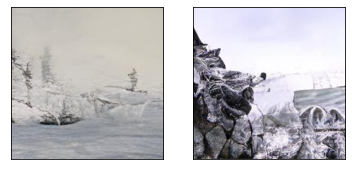

In [10]:
make_images('snow located on the grand canyon.', 2)